In [1]:
#import av
import numpy as np
import math
from skimage.morphology import *
from skimage.feature import *
import matplotlib.pyplot as plt #for maknig plots inside the notebook
import skimage
import skvideo.io
from operator import attrgetter
import seaborn as sns
from operator import attrgetter
from itertools import chain
from skimage import measure
from skimage import morphology
from skimage.util import invert
from skimage.filters import *
from scipy import ndimage
from glob import glob
from skvideo.io import vreader
"""Currently works on a single frame. Later, will add a loop that can work on all frames."""

'Currently works on a single frame. Later, will add a loop that can work on all frames.'

In [2]:
# take largest isodata image region, and return aclassification
def sideify(ptotallengths,mtotallengths, num_pconnections, num_mconnections):    
    if num_mconnections == 2 and num_pconnections == 3:# and num_mconnections==4: #gtotallengths>48
        return "t"
    elif num_mconnections == 3 and num_pconnections == 2:# and num_mconnections == 4:
        return "c"
    else:
        return "ucf"
    
def connect(cv, radius, bloblist): # center of blob2, radius of all blobs, list of other blobs
    num_connections = 0
    norm_radius = 15
    total_separations = 0
    normalized_dists = []
    for blob2 in bloblist:
        cv2 = (blob2[1], blob2[0]) # center of blob2
        vector_d = vector_dist(cv, cv2)
        total_separations += vector_d
        if vector_d <= 2*radius and vector_d > .2*radius: # blob centers closer than diameter of one blob
            num_connections += 1
        else:
            pass
        if vector_d <= 4*radius: 
            normalized_dists.append(vector_d/(2*norm_radius))
    return (num_connections, normalized_dists, total_separations)

def vector_dist(v1, v2): # euclidean distance between 2 points
    return math.sqrt(np.sum([(v1[i] - v2[i])**2 for i in range(len(v1))]))

def third_item(l1):
        return l1[2]        

#from pair of labelled, thresholded images, return an image category (of three)

#from pair of labelled,thresholded images, return the x/y sign or x/y magnitude for the transparent dot


In [3]:
connect_test = connect((0, 0),2, [(0, 3, 1), (3, 3, 1.1), (0, 0, 5), (9, 9, 100)]) #2
vector_dist_test = [vector_dist((-3, 0), (0, 4)), vector_dist((1,1,0), (1,7,8))]
third_item_test = third_item([0, "99", "hello", [55, 67]])
print(connect_test, vector_dist_test , third_item_test )

(1, [0.1, 0.1414213562373095, 0.0], 19.97056274847714) [5.0, 10.0] hello


In [4]:
grp1 = [1, [95, 67], 2]
grp2 = [2, [9.0], 13]
print(grp1+grp2)
print([grp1[i]+grp2[i] for i in range(len(grp1))])

[1, [95, 67], 2, 2, [9.0], 13]
[3, [95, 67, 9.0], 15]


In [5]:
"Filtering broken ad oddframes"
"USING LI THRESHOLD"
# apply total thresholding to each of a list of frames; filter slides with wrong number
def total_threshold_filter(framelist, framesetname): 
    # returns a new list, different from the orginal
    fll = len(framelist)
    m_lab = measure.label
    m_rop = measure.regionprops
    expected_blobs = 4
    expected_connections = 5
    p_bond = 15*1
    m_bond = 15*1.1
    
    filtrate_prop =[]
    passes = []
    all_props = []
    blobset = [] #labelled imgs
    for i in range(fll):
       # ---setup image and detect blobs ----------------
        if framesetname == 'broken' or framesetname == 'odd_s':
            framesetname = 'ucf'
        frame = framelist[i]
        thresh_img = frame > threshold_isodata(frame)# binary image
        
        phighlight = morphology.binary_opening(thresh_img, disk(7))
        img = np.copy(frame)
        img[phighlight==0] = 0
        pblobs =skimage.feature.blob_dog(img, min_sigma = 8, max_sigma = 12, threshold = 0.05, overlap=0.3)
        pblobs[:, 2] = pblobs[:, 2] * np.sqrt(2)
        ghighlight = morphology.binary_opening(morphology.white_tophat(gaussian(thresh_img, sigma=0.3), disk(7)),disk(3))
        
        img = np.copy(frame)
        img[ghighlight==0] = 0
        gblobs =skimage.feature.blob_doh(img, min_sigma = 6, max_sigma = 9, threshold = 0.02, overlap=0.5)
        
        if len(gblobs) ==0 and len(pblobs)==0:
            pass
        else:
            blobset.append([pblobs, gblobs])
            ngblobs = len(gblobs)
            npblobs = len(pblobs) 
            num_blobs = ngblobs + npblobs  

            plas_on_glas_dists =[connect((gblob[1], gblob[0]),m_bond, pblobs) for gblob in gblobs]
            plas_on_glas_dists = [sum([pog[0] for pog in plas_on_glas_dists]), 
                                  list(chain(*[pog[1] for pog in plas_on_glas_dists])),
                                 sum([pog[2] for pog in plas_on_glas_dists])]
            num_mconnections = plas_on_glas_dists[0]
            mdistances = plas_on_glas_dists[1]
            mtotallengths = plas_on_glas_dists[2]

            plas_on_plas_dists = [connect((pblobs[i][1], pblobs[i][0]),p_bond, pblobs[i+1:]) for i in range(npblobs-1)]
            plas_on_plas_dists = [sum([pop[0] for pop in plas_on_plas_dists]), 
                                  list(chain(*[pop[1] for pop in plas_on_plas_dists])),
                                 sum([pop[2] for pop in plas_on_plas_dists])]
            num_pconnections = plas_on_plas_dists[0]
            pdistances = plas_on_plas_dists[1]
            ptotallengths = plas_on_plas_dists[2]


            num_connections = sum([num_pconnections,num_mconnections])
            distances = list(chain(pdistances, mdistances))       
            totallengths = sum([ ptotallengths, mtotallengths])

            #----------------------filter------------------------- can use actual filter
            properties = {'num_blobs':num_blobs,
                          'num_pblobs':npblobs,
                          'num_gblobs':ngblobs,
                          'num_connections': num_connections,
                          'num_pconnections':num_pconnections, 
                          'num_mconnections':num_mconnections,
                         'totallengths':totallengths,  
                          'ptotallengths':ptotallengths, 
                          'mtotallengths':mtotallengths,
                         'distances':distances, 
                          'pdistances':pdistances, 
                          'mdistances':mdistances}
            #print(properties)
            all_props.append(properties)

            #print('blobs, max_blob, max_rad, num_connections, cons_of_max:', (blobs, max_blob, max_rad, num_connections, cons_of_max))    
            test = (num_connections >= expected_connections and num_blobs>=expected_blobs)
            if test: 
                #-----------------------------classify pt 1---------------------------------------
                clas = sideify(ptotallengths,mtotallengths,num_pconnections, num_mconnections )
                filtrate_prop.append(properties)
            else:
                clas = 'ucf'
            if clas == framesetname:
                passes.append(properties)
            
    return [filtrate_prop, passes, all_props, blobset]






In [6]:
filenames = glob("./tchakamau/De*ethylene/*_[0].avi")+glob("./tchakamau/De*ethylene/*_[9].avi")#glob("./tchakamau/New_setup/*.avi")# glob("./tchakamau/New_setup/45681_10Vpp_25.avi") #filenames = 
print(filenames)
num_shape_cats = 4
Pass_ratios = np.zeros((len(filenames), num_shape_cats))



"""TEST FRAME RANGES FROM VIDEOs"""
phantom_frames = {"t" : list(range(1, 150, 1)),
                  "c" :list(range(500, 650, 1)), 
                 "broken" :list(range(1600, 1750, 1)) ,
                 "odd_s" :list(chain(range(410,437, 1), range(1765, 1817, 1))) }


phantom_frames_2 = {"t" : list(range(15352, 15896, 1)),
                  "c" :list(range(1, 600,4)), 
                 "broken" :list(range(2175, 5843, 40)) ,
                 "odd_s" :list(range(10455,10472, 1)) }
"""phantom_frames_3 = {"t" :list(range(30104, 29591, -1)),
                  "c" :list(range(30816, 30375, -2)), 
                 "broken" :list(range(30340, 30288, -1)) ,
                 "odd_s" :[]}"""
phantom_frame_sets = [phantom_frames,phantom_frames_2]
trigger_frames = [1, 1]#[13268, 18192, 2964, 8535]



['./tchakamau\\Density_matchedethylene\\45696_15Vpp_0.avi', './tchakamau\\Density_matchedethylene\\45693_15Vpp_9.avi']


In [7]:
p_frames = []

g_frames = []

b_frames = []

odd_s_frames = []

broken_frames = []


framesets = [p_frames, g_frames, b_frames,  odd_s_frames, 
             broken_frames]
framesetnames = ["t", "c", "odd_s", "broken"]
filtrates_props = []
passes = []
i_props = []
t_props = []    
for vidnum in range(len(filenames)):
    framegen = vreader(filenames[vidnum])
    #frame_vid = frames[:, :, :, 2]# making videos ino a frame list
    print(framegen)
    pvals  = []
    gvals = []
    bvals = []
    oddsvals = []
    brokenvals = []
    frametypevals = [pvals, gvals, bvals, oddsvals, brokenvals]
    
    for framesetind in range(len(framesetnames)):
        typevals = (phantom_frame_sets[vidnum].get(framesetnames[framesetind]))
        frametypevals[framesetind].extend(typevals)
    frameindex = 0
    tf = trigger_frames[vidnum]
    for frame in framegen:
        for framesetind in range(len(framesetnames)):            
            if abs(tf-frameindex) in frametypevals[framesetind]:
                framesets[framesetind].append((frame[:,:,2], abs(tf-frameindex)))
           
        frameindex += 1
    
    
""" for i in range(len(framesetnames)):
        typevals = phantom_frame_sets[vidnum].get(framesetnames[i])
        
        frames = 
        #print(len(typevals), trigger_frames[vidnum], typevals[-1], typevals[-1]-trigger_frames[vidnum])
        framesets[i].extend([(frame_vid[trigger_frames[vidnum]-x], x) for x in typevals])
"""

<generator object vreader at 0x000001C348B20848>
<generator object vreader at 0x000001C348B204C8>


' for i in range(len(framesetnames)):\n        typevals = phantom_frame_sets[vidnum].get(framesetnames[i])\n        \n        frames = \n        #print(len(typevals), trigger_frames[vidnum], typevals[-1], typevals[-1]-trigger_frames[vidnum])\n        framesets[i].extend([(frame_vid[trigger_frames[vidnum]-x], x) for x in typevals])\n'

In [8]:
filtrates_props = []
passes = []
a_props = []
p_rats = []
limgs = []
for i in range(len(framesetnames)):
    x = total_threshold_filter([y[0] for y in framesets[i]], framesetnames[i])
    filtrates_props.append(x[0])
    passes.append(x[1])
    #all_props.append(x[2])
    #print(framesets[i])

    orig = len(framesets[i])
    fil = len(x[0])
    pas = len(x[1])
    print(orig, fil, pas)
    print(framesetnames[i], "_vid")
    print("original_vid: ", orig)
    print("filtrate: ", fil)
    if orig != 0:
        print("pass ratio: ", pas*100/orig)
        p_rats.append(pas*100/orig)
    print("\n")
        

    a_props.append(x[2])
    limgs.append(x[3])
Pass_ratios = p_rats
Filtrates_props = filtrates_props
st = framesets
np.save('shape_testing.npy',st)
print(len(a_props), len(filtrates_props), len(passes))

694 694 673
t _vid
original_vid:  694
filtrate:  694
pass ratio:  96.97406340057637


301 251 251
c _vid
original_vid:  301
filtrate:  251
pass ratio:  83.38870431893687


96 31 65
odd_s _vid
original_vid:  96
filtrate:  31
pass ratio:  67.70833333333333


242 0 242
broken _vid
original_vid:  242
filtrate:  0
pass ratio:  100.0


4 4 4


In [9]:
names = {'num_blobs':[],
                      'num_pblobs':[],
                      'num_gblobs':[],
                      'num_connections': [],
                      'num_pconnections':[], 
                      'num_mconnections':[],
                     'totallengths':[],  
                      'ptotallengths':[], 
                      'mtotallengths':[],
                     'distances':[],  
                      'pdistances':[], 
                      'mdistances':[]}
strings = names.keys()
distances = [string for string in strings if 'distances' in string]
simplenames = strings - distances
print(distances, simplenames)

['distances', 'pdistances', 'mdistances'] {'mtotallengths', 'num_gblobs', 'num_pconnections', 'num_blobs', 'num_connections', 'num_pblobs', 'totallengths', 'num_mconnections', 'ptotallengths'}


mtotallengths averages: 
t : 88 
c : 70 
odd_s : 69 
broken : 181 
mtotallengths variances: 
t : 198 
c : 171 
odd_s : 864 
broken : 10607 
num_gblobs averages: 
t : 1 
c : 1 
odd_s : 1 
broken : 1 
num_gblobs variances: 
t : 0 
c : 0 
odd_s : 0 
broken : 0 
num_pconnections averages: 
t : 3 
c : 2 
odd_s : 2 
broken : 1 
num_pconnections variances: 
t : 0 
c : 0 
odd_s : 1 
broken : 1 
num_blobs averages: 
t : 4 
c : 4 
odd_s : 4 
broken : 4 
num_blobs variances: 
t : 0 
c : 0 
odd_s : 0 
broken : 0 
num_connections averages: 
t : 5 
c : 5 
odd_s : 4 
broken : 2 
num_connections variances: 
t : 0 
c : 1 
odd_s : 2 
broken : 1 
num_pblobs averages: 
t : 3 
c : 3 
odd_s : 3 
broken : 3 
num_pblobs variances: 
t : 0 
c : 0 
odd_s : 0 
broken : 0 
totallengths averages: 
t : 158 
c : 154 
odd_s : 168 
broken : 358 
totallengths variances: 
t : 208 
c : 765 
odd_s : 1589 
broken : 20843 
num_mconnections averages: 
t : 2 
c : 3 
odd_s : 2 
broken : 1 
num_mconnections variances: 
t : 0 
c 

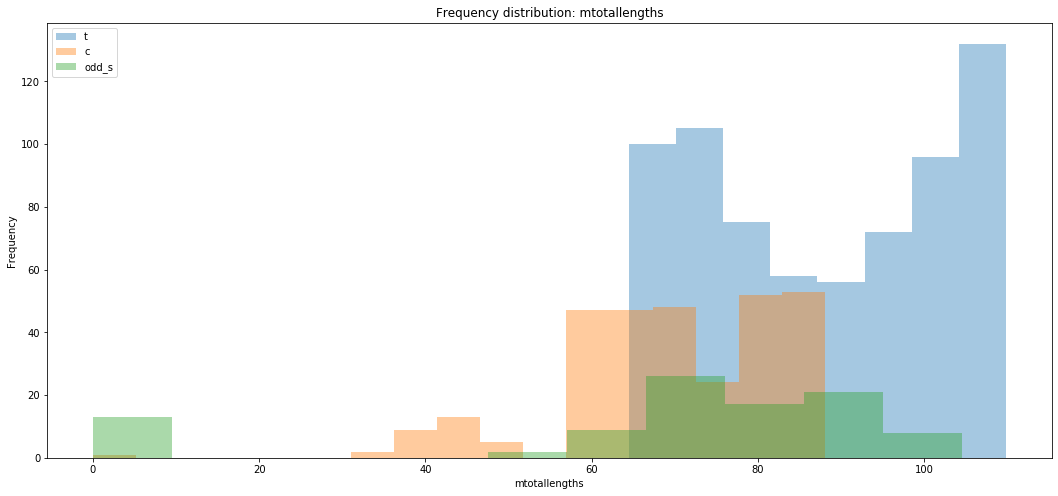

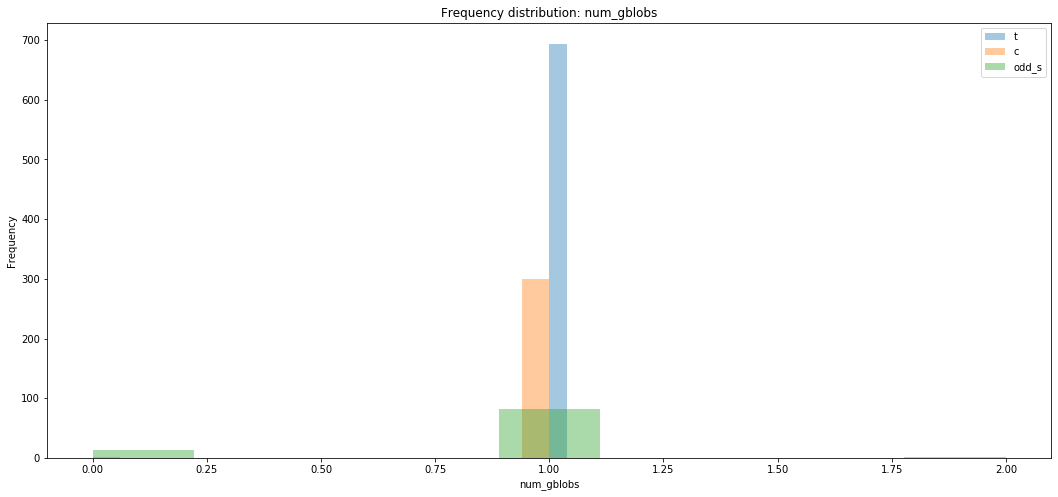

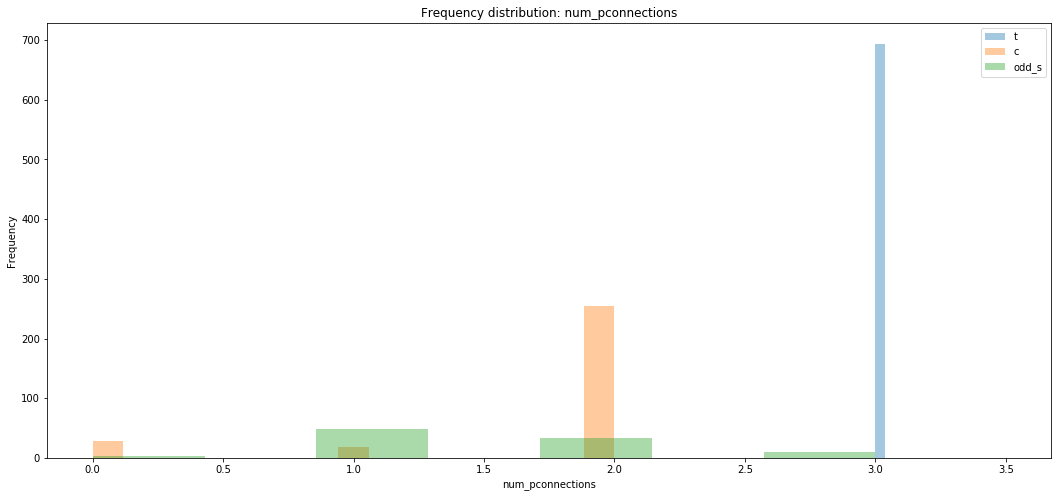

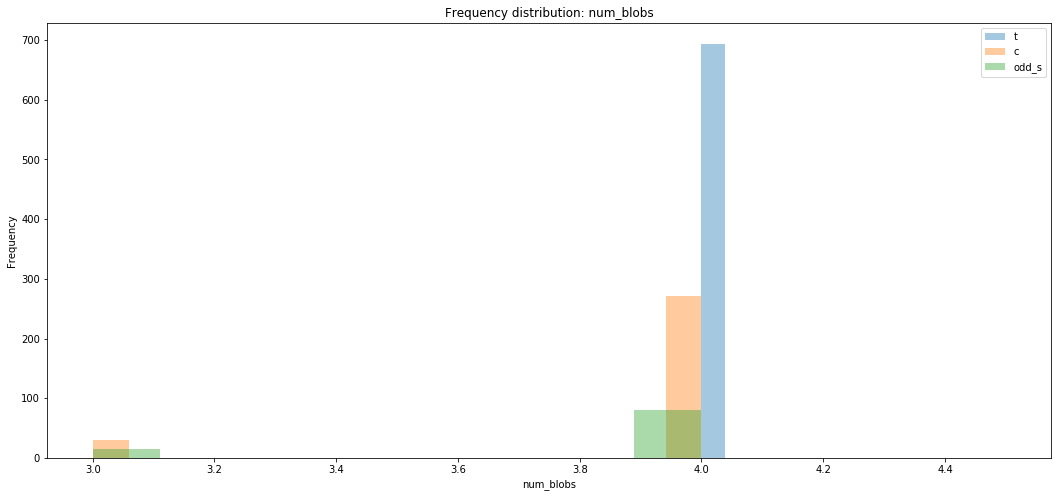

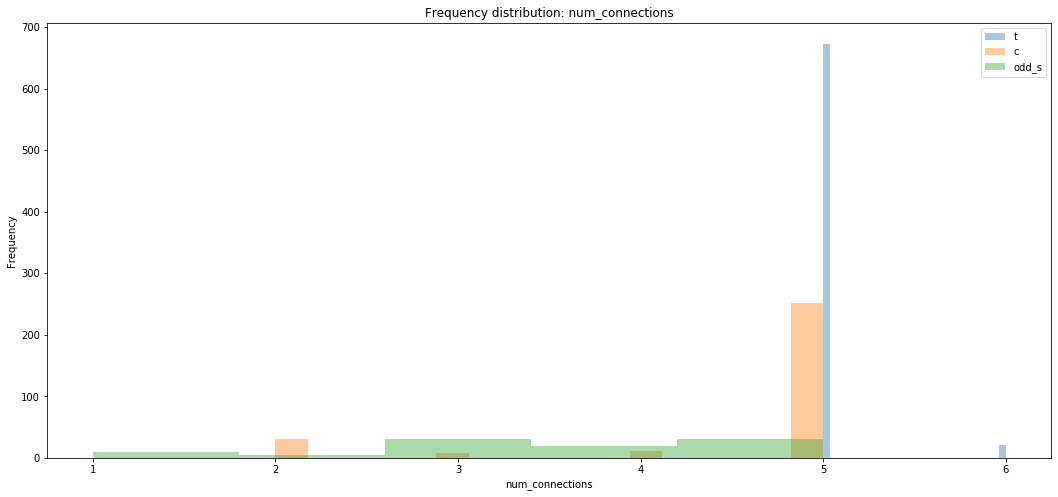

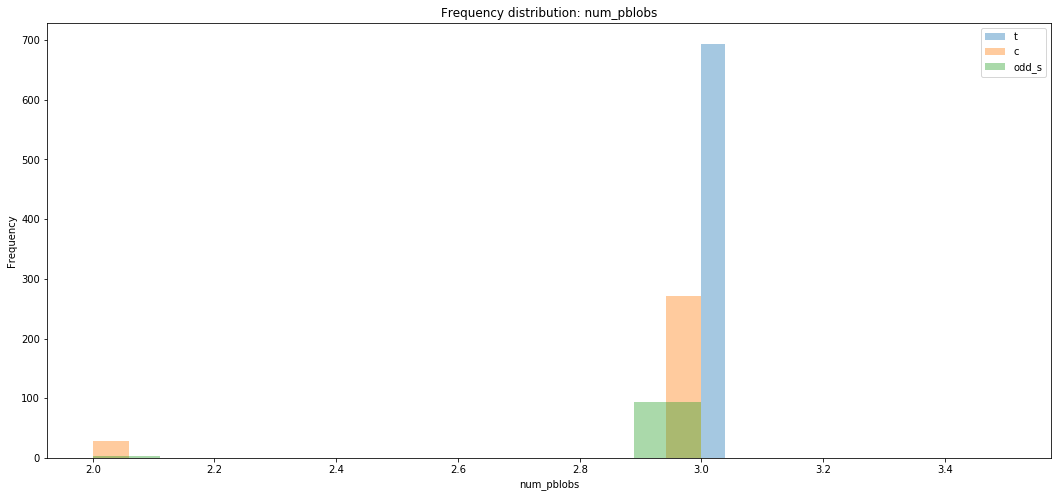

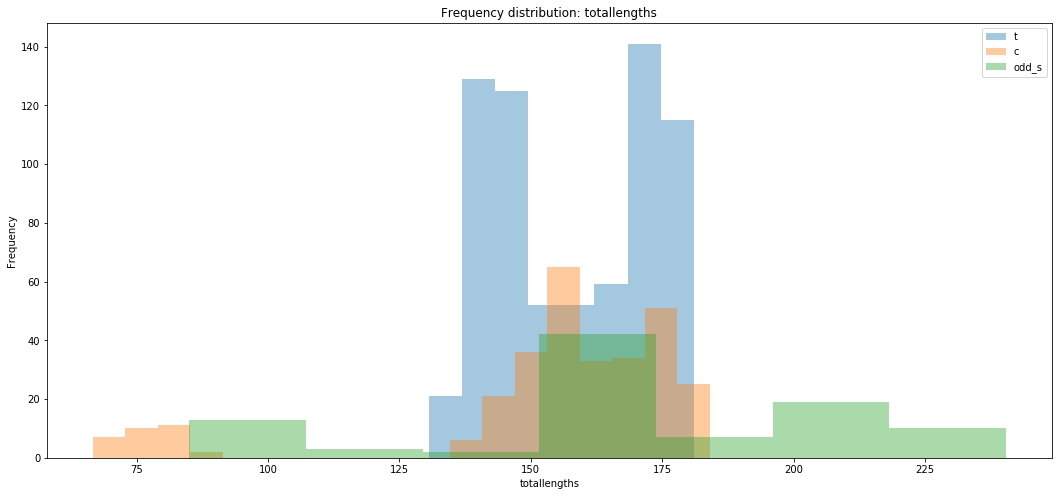

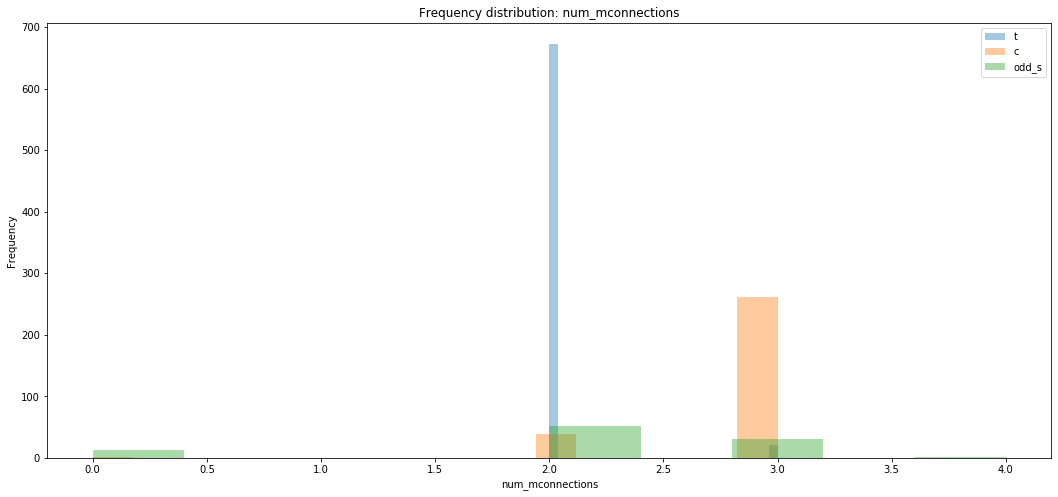

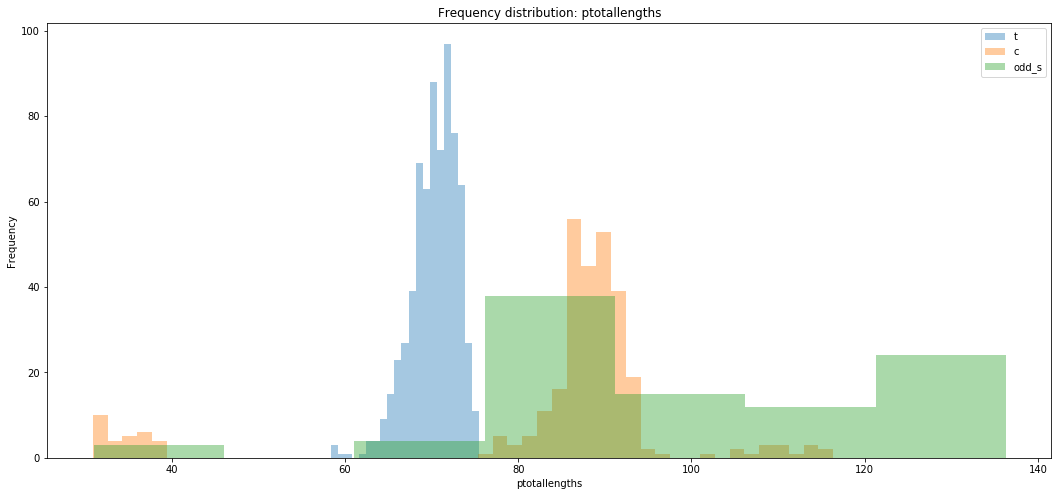

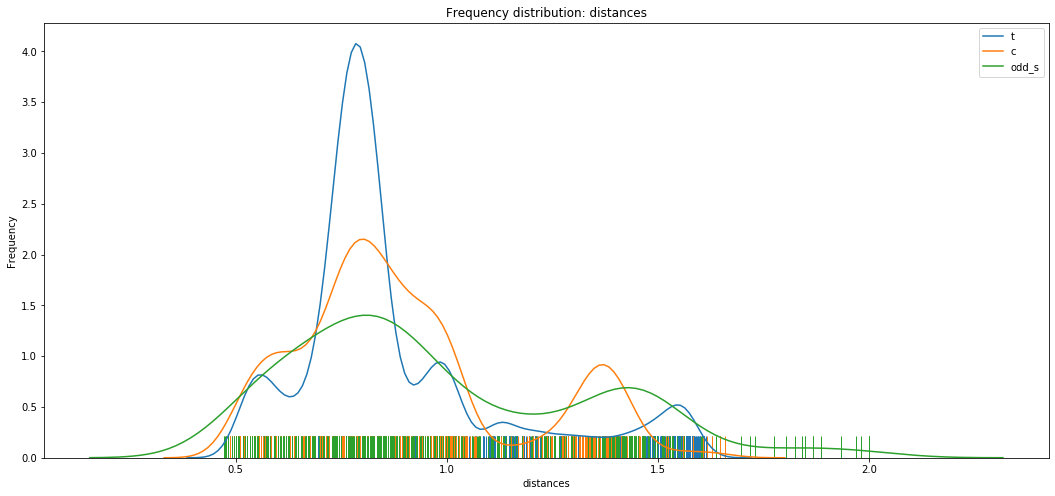

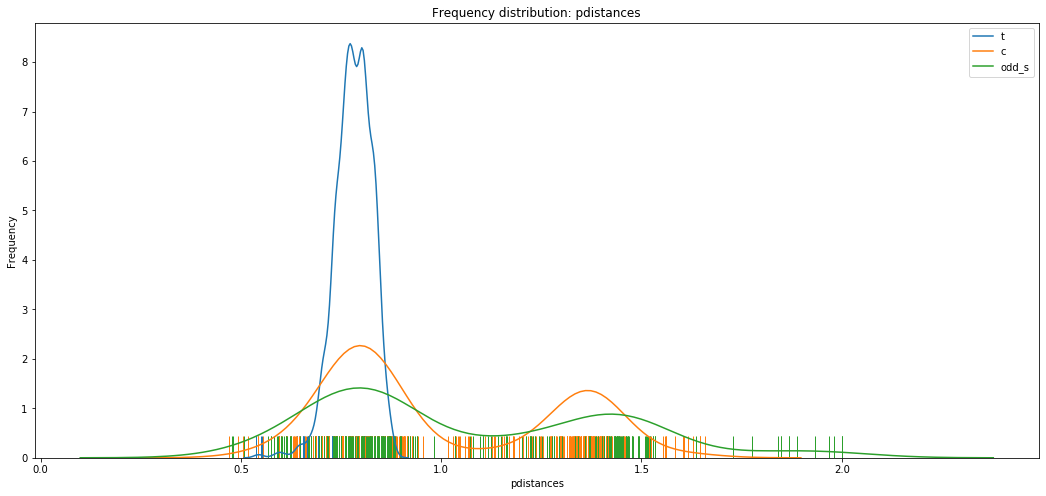

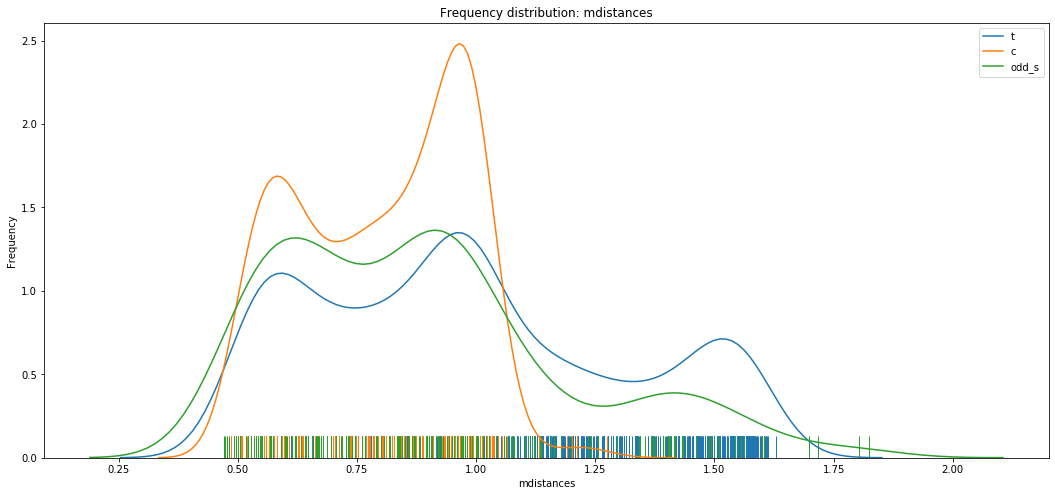

In [13]:
"""Everything"""

# use area information from properties


for name in simplenames:
    klist = []
    for i in range(num_shape_cats):
        x = [h[name] for h in a_props[i]]
        klist.append(x) #list of areas for every category
    print("%s averages: " %name)
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: " %name)
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " + name)
    plt.xlabel(name)
    plt.ylabel("Frequency")
    for j in range(0, num_shape_cats-1):
        x = klist[j]
        sns.distplot(x, hist = True, kde=False,rug=False, label = framesetnames[j])
    plt.legend() 
    
    

    
    
print(len(klist[0]))
#num_shape_cats = 4
#num_shape_cats = num_shape_cats-2
for name in distances:
    klist = []
    for i in range(num_shape_cats):
        x = [d for lis in [h[name] for h in a_props[i]] for d in lis]
        klist.append(x) #list of areas for every category
    print(len(klist[0]))
    print("%s averages: " %name)
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: "  %name)
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " +  name)
    plt.xlabel( name)
    plt.ylabel("Frequency")
    for j in range(0, num_shape_cats-1):
        x = klist[j]
        sns.distplot(x, hist = False, rug=True, label = framesetnames[j])




mtotallengths averages: 
t : 88 
c : 73 
odd_s : 75 
broken : nan 
mtotallengths variances: 
t : 198 
c : 89 
odd_s : 91 
broken : nan 
num_gblobs averages: 
t : 1 
c : 1 
odd_s : 1 
broken : nan 
num_gblobs variances: 
t : 0 
c : 0 
odd_s : 0 
broken : nan 
num_pconnections averages: 
t : 3 
c : 2 
odd_s : 2 
broken : nan 
num_pconnections variances: 
t : 0 
c : 0 
odd_s : 0 
broken : nan 
num_blobs averages: 
t : 4 
c : 4 
odd_s : 4 
broken : nan 
num_blobs variances: 
t : 0 
c : 0 
odd_s : 0 
broken : nan 
num_connections averages: 

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)



t : 5 
c : 5 
odd_s : 5 
broken : nan 
num_connections variances: 
t : 0 
c : 0 
odd_s : 0 
broken : nan 
num_pblobs averages: 
t : 3 
c : 3 
odd_s : 3 
broken : nan 
num_pblobs variances: 
t : 0 
c : 0 
odd_s : 0 
broken : nan 
totallengths averages: 
t : 158 
c : 161 
odd_s : 158 
broken : nan 
totallengths variances: 
t : 208 
c : 119 
odd_s : 33 
broken : nan 
num_mconnections averages: 
t : 2 
c : 3 
odd_s : 3 
broken : nan 
num_mconnections variances: 
t : 0 
c : 0 
odd_s : 0 
broken : nan 
ptotallengths averages: 
t : 70 
c : 88 
odd_s : 83 
broken : nan 
ptotallengths variances: 
t : 7 
c : 11 
odd_s : 33 
broken : nan 
694
4164
distances averages: 
t : 1 
c : 1 
odd_s : 1 
broken : nan 
distances variances: 
t : 0 
c : 0 
odd_s : 0 
broken : nan 
2082
pdistances averages: 
t : 1 
c : 1 
odd_s : 1 
broken : nan 
pdistances variances: 
t : 0 
c : 0 
odd_s : 0 
broken : nan 
2082
mdistances averages: 
t : 1 
c : 1 
odd_s : 1 
broken : nan 
mdistances variances: 
t : 0 
c : 0 
od

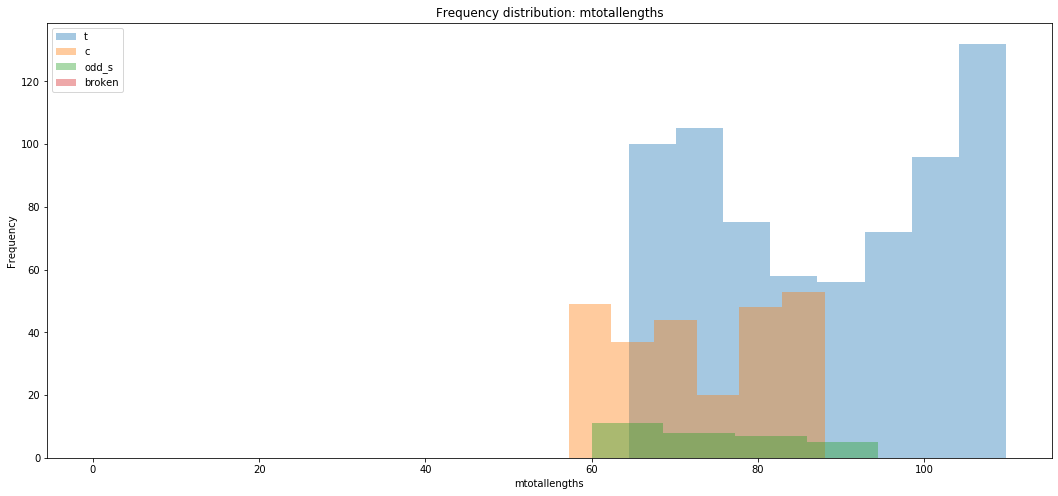

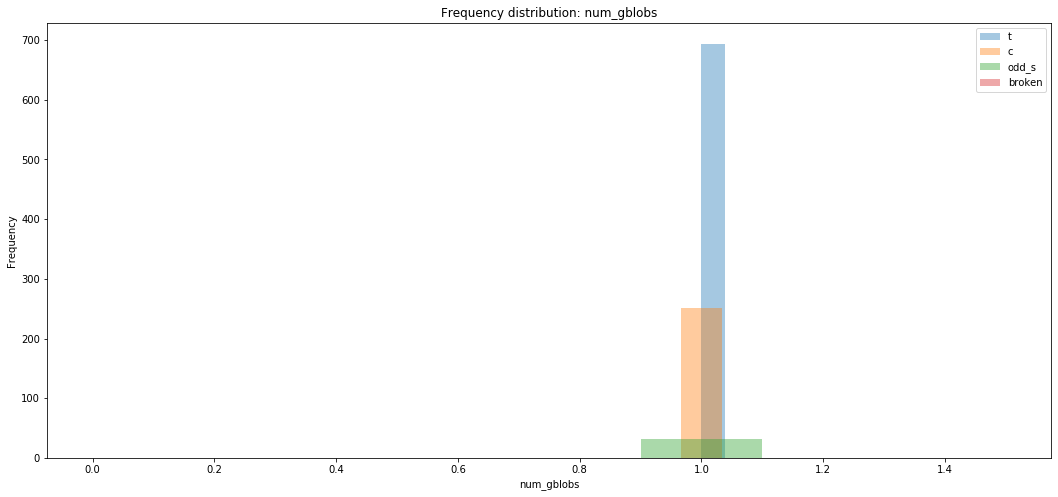

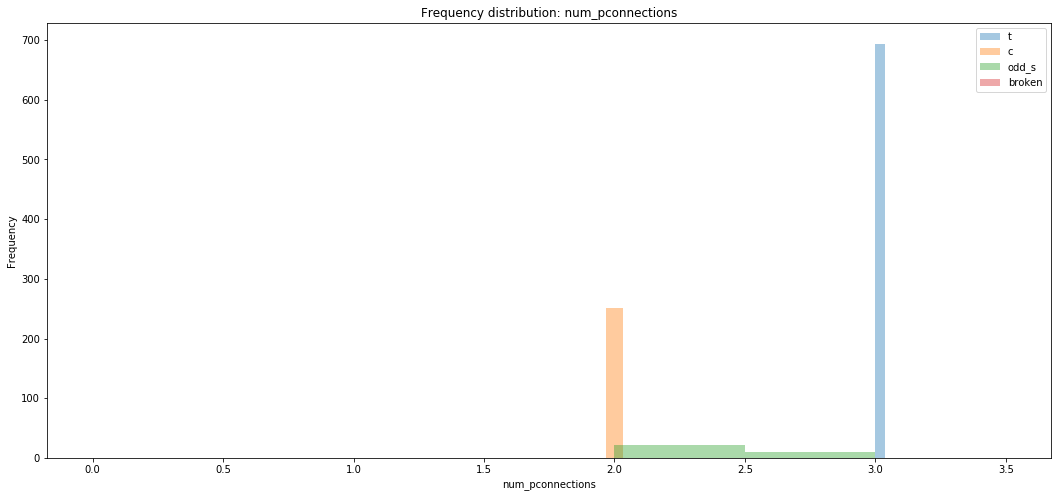

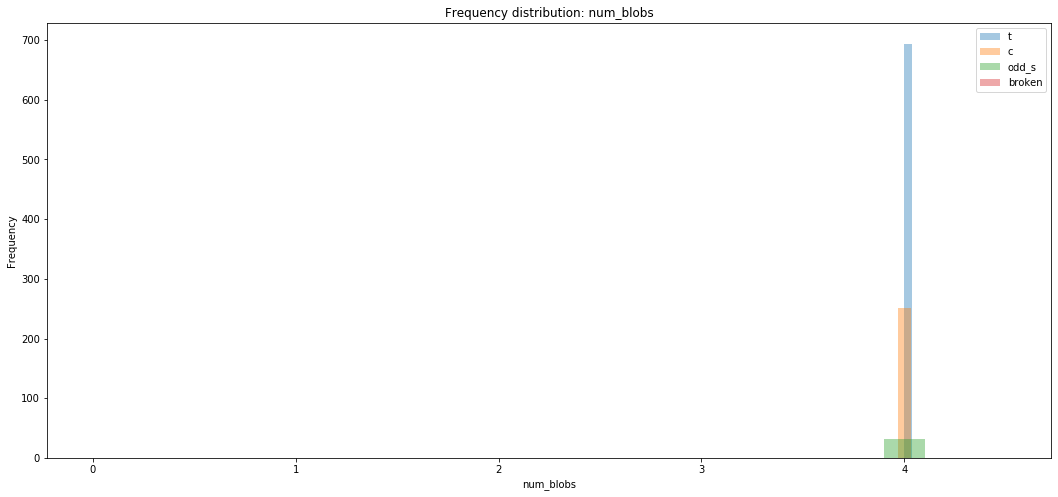

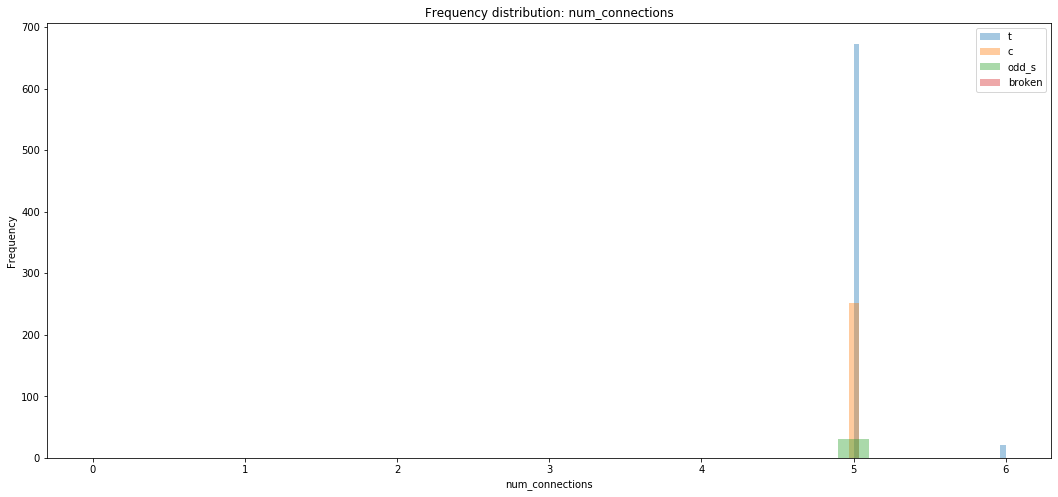

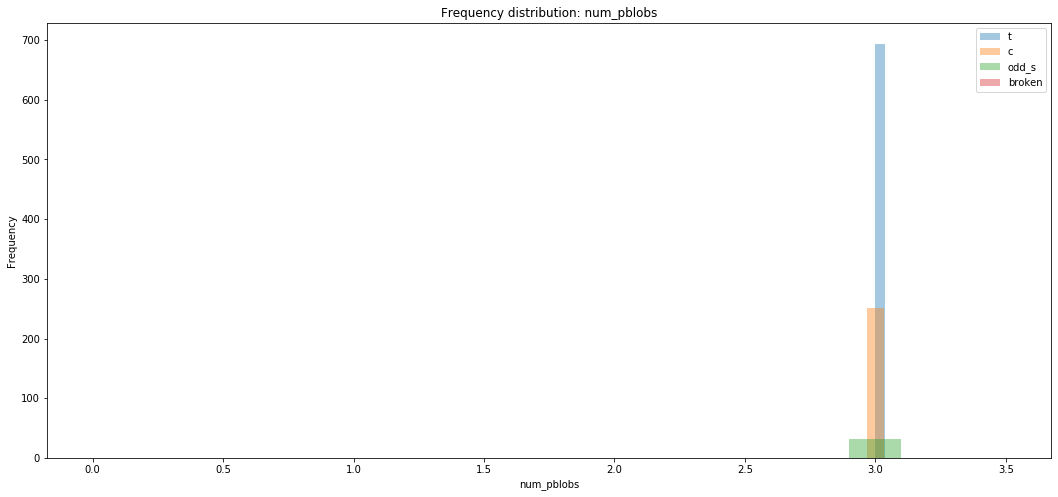

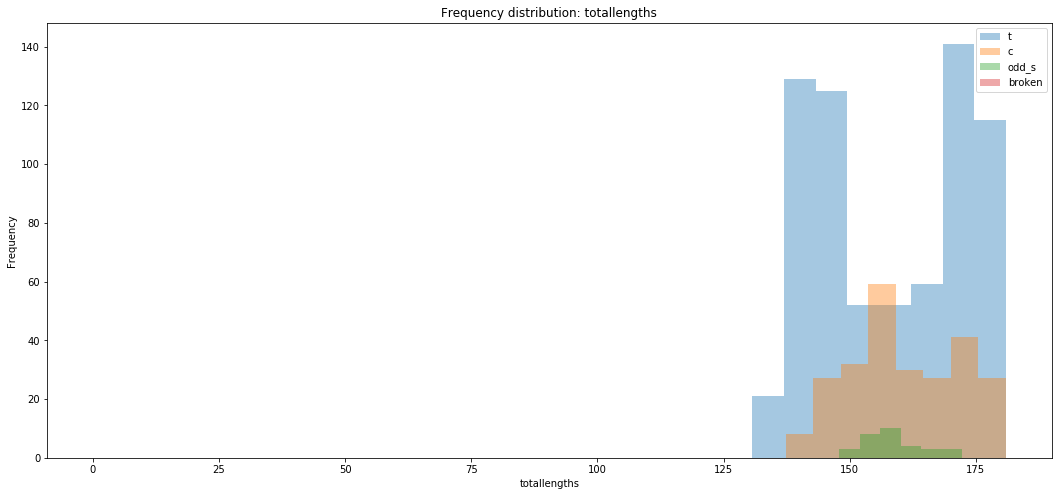

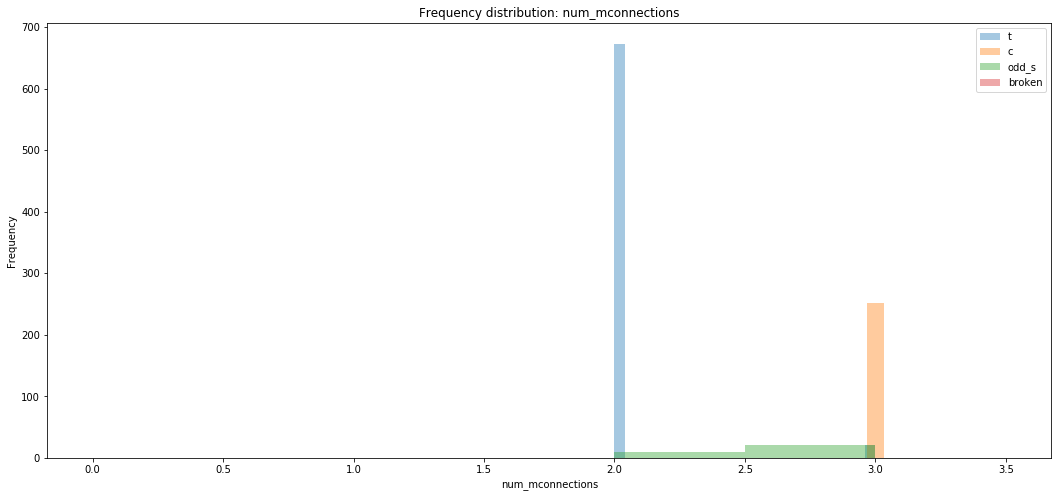

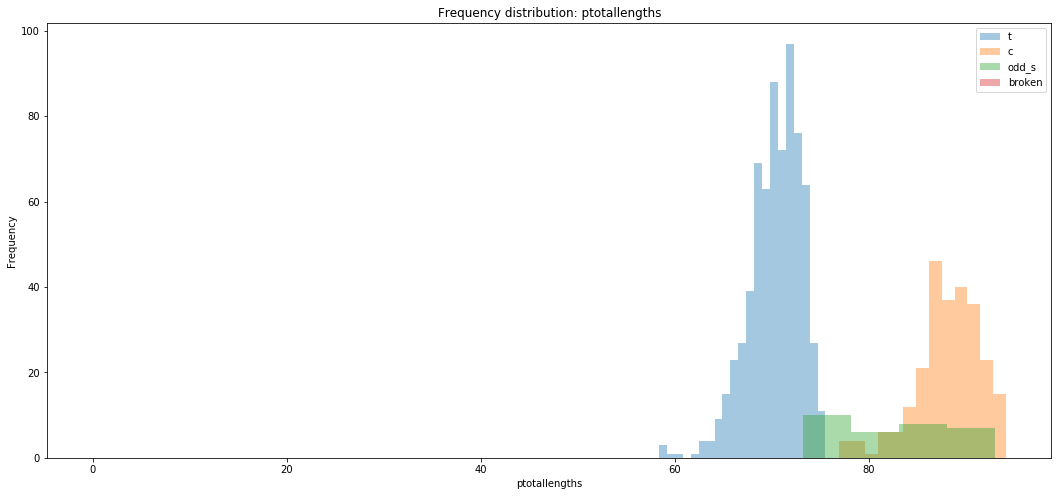

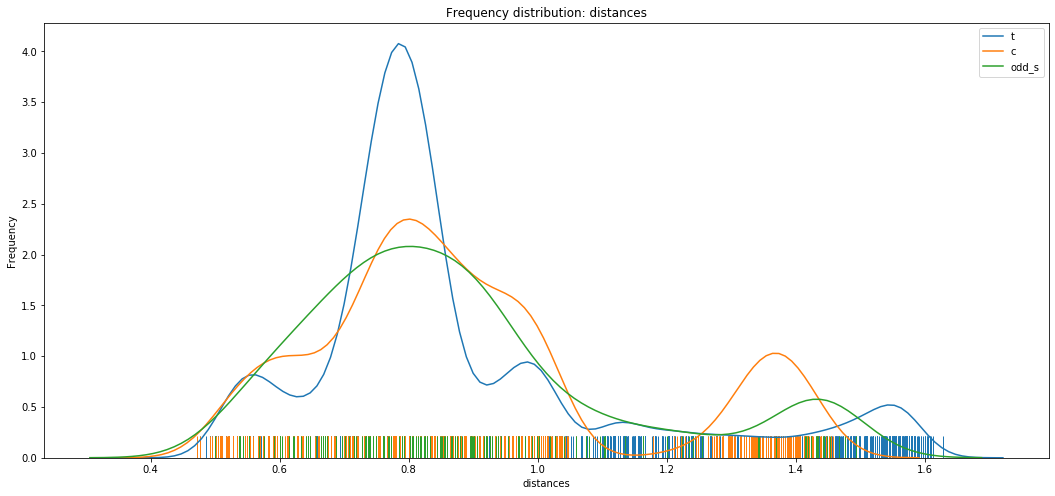

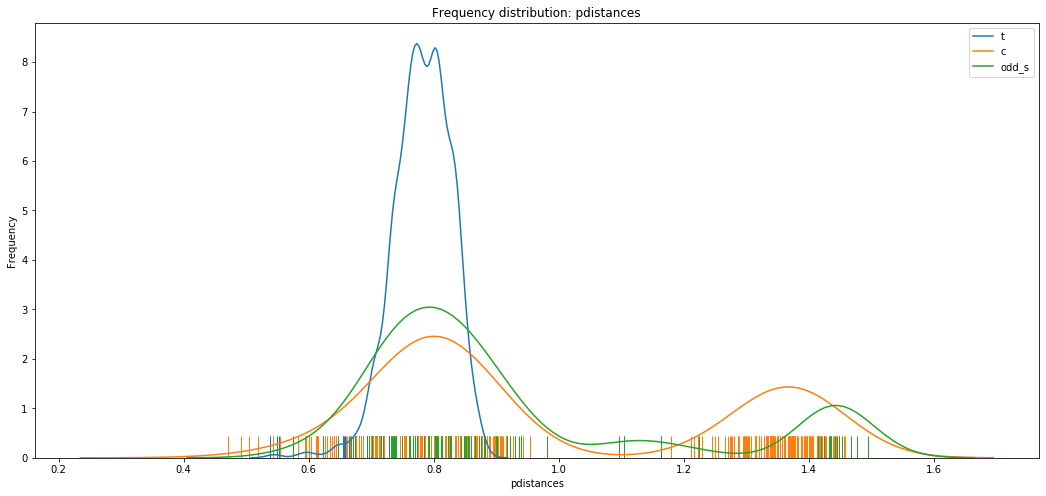

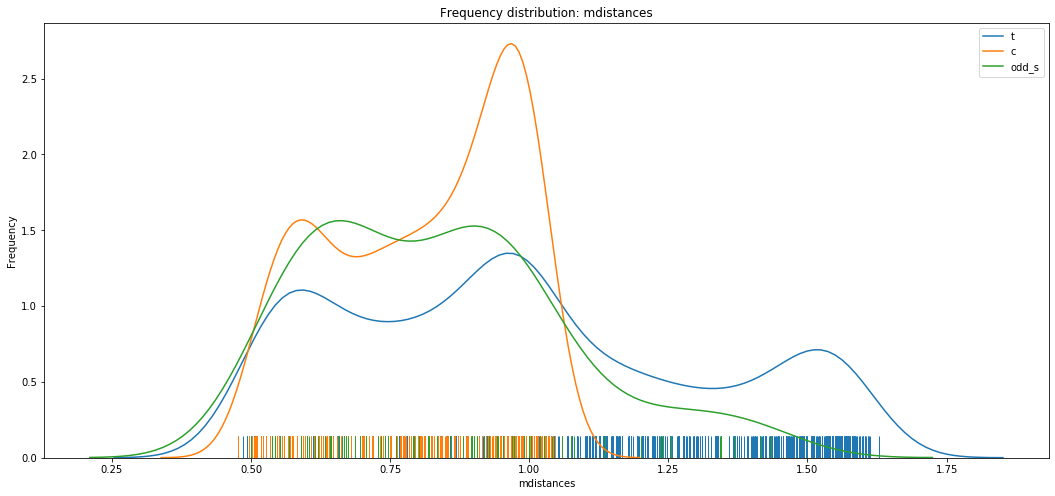

In [11]:
"""After first tests"""
# use area information from properties


for name in simplenames:
    klist = []
    for i in range(num_shape_cats):
        x = [h[name] for h in filtrates_props[i]]
        klist.append(x) #list of areas for every category
    print("%s averages: " %name)
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: " %name)
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " + name)
    plt.xlabel(name)
    plt.ylabel("Frequency")
    for j in range(0, num_shape_cats):
        x = klist[j]
        sns.distplot(x, hist = True, kde=False,rug=False, label = framesetnames[j])
    plt.legend() 
    
    

    
    
print(len(klist[0]))
for name in distances:
    klist = []
    for i in range(num_shape_cats):
        x = [d for lis in [h[name] for h in filtrates_props[i]] for d in lis]
        klist.append(x) #list of areas for every category
    print(len(klist[0]))
    print("%s averages: " %name)
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: "  %name)
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " +  name)
    plt.xlabel( name)
    plt.ylabel("Frequency")
    for j in range(0, num_shape_cats-1):
        x = klist[j]
        sns.distplot(x, hist = False, rug=True, label = framesetnames[j])



"""Broken objects are filtered out by their area and we then move on to identifying odd shaped objects 
    from the remaining frames"""
framesets.remove(broken_frames)
framesetnames.remove("broken")

mtotallengths averages: 
t : 89 
c : 73 
odd_s : 66 
broken : 181 
mtotallengths variances: 
t : 190 
c : 89 
odd_s : 1202 
broken : 10607 
num_gblobs averages: 
t : 1 
c : 1 
odd_s : 1 
broken : 1 
num_gblobs variances: 
t : 0 
c : 0 
odd_s : 0 
broken : 0 
num_pconnections averages: 
t : 3 
c : 2 
odd_s : 1 
broken : 1 
num_pconnections variances: 
t : 0 
c : 0 
odd_s : 0 
broken : 1 
num_blobs averages: 
t : 4 
c : 4 
odd_s : 4 
broken : 4 
num_blobs variances: 
t : 0 
c : 0 
odd_s : 0 
broken : 0 
num_connections averages: 
t : 5 
c : 5 
odd_s : 3 
broken : 2 
num_connections variances: 
t : 0 
c : 0 
odd_s : 1 
broken : 1 
num_pblobs averages: 
t : 3 
c : 3 
odd_s : 3 
broken : 3 
num_pblobs variances: 
t : 0 
c : 0 
odd_s : 0 
broken : 0 
totallengths averages: 
t : 159 
c : 161 
odd_s : 173 
broken : 358 
totallengths variances: 
t : 198 
c : 119 
odd_s : 2261 
broken : 20843 
num_mconnections averages: 
t : 2 
c : 3 
odd_s : 2 
broken : 1 
num_mconnections variances: 
t : 0 
c 

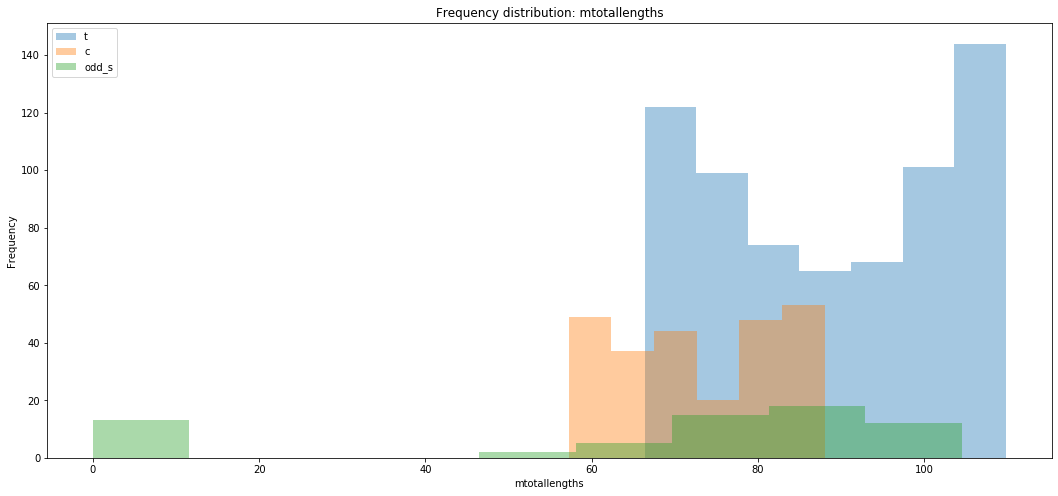

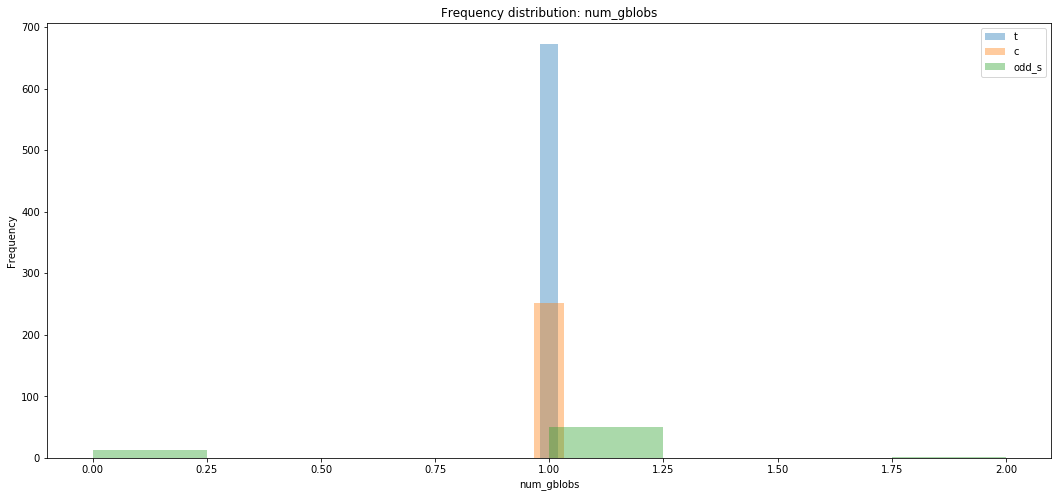

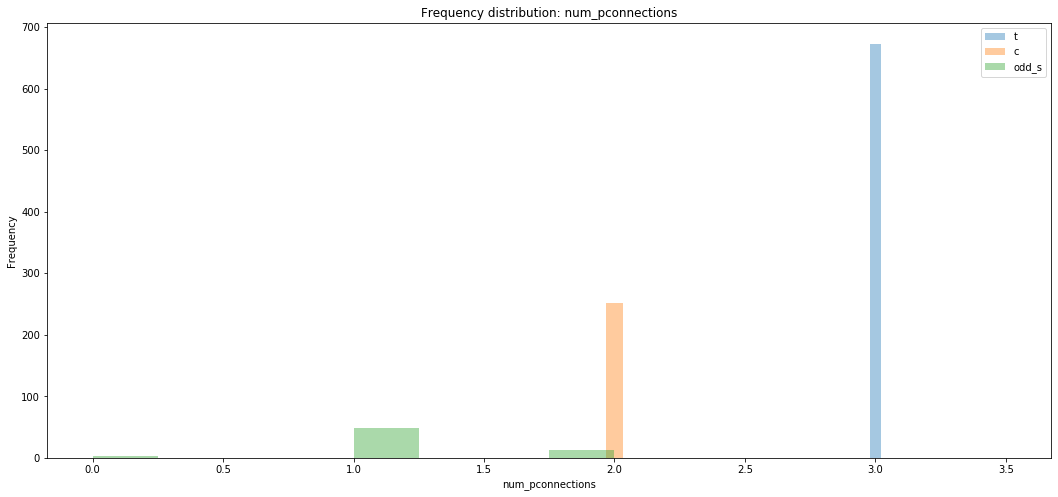

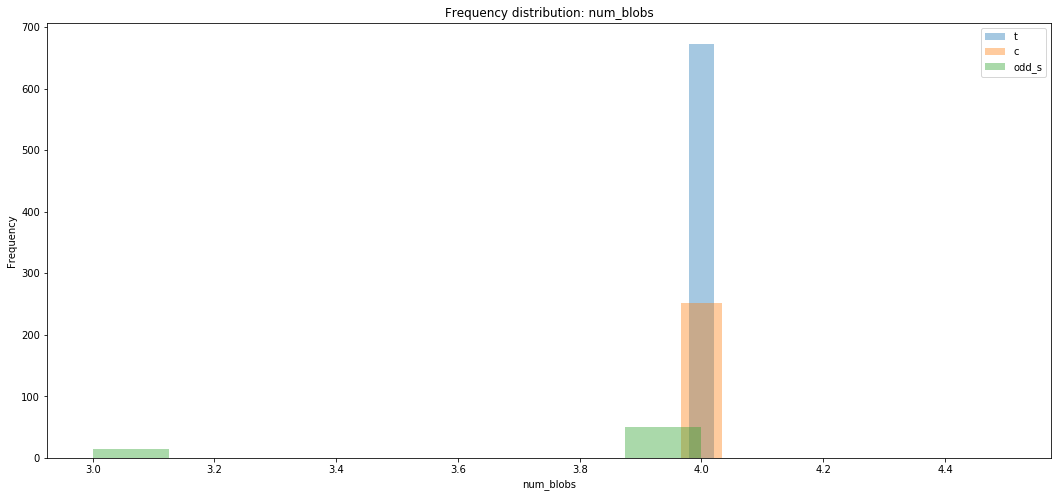

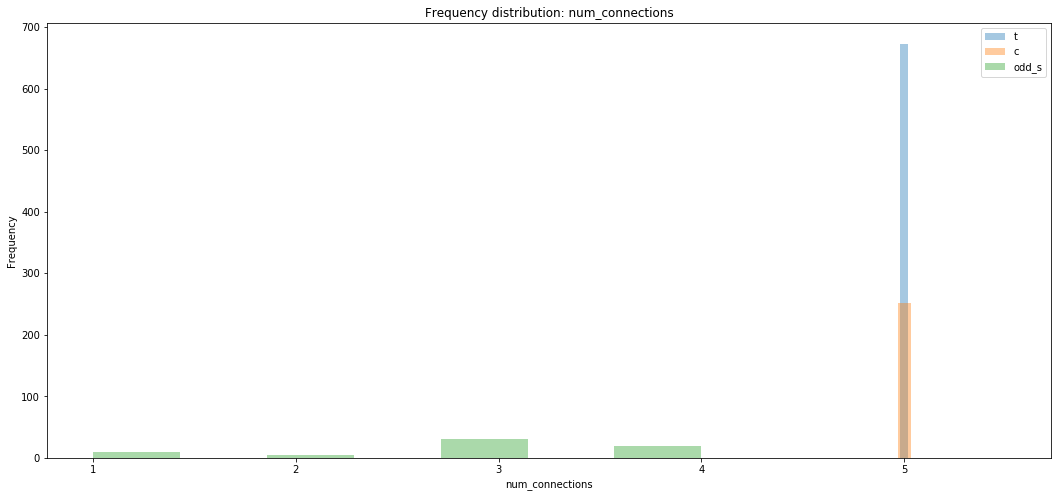

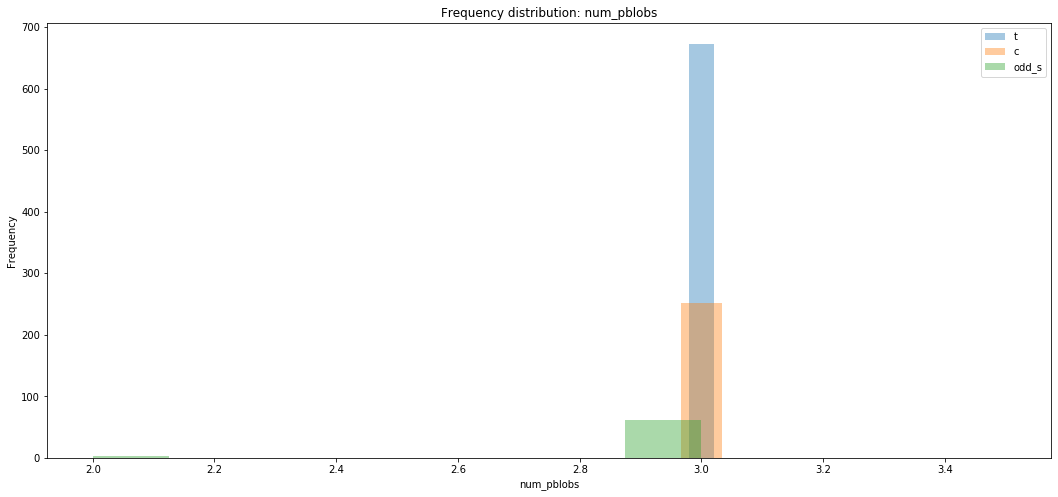

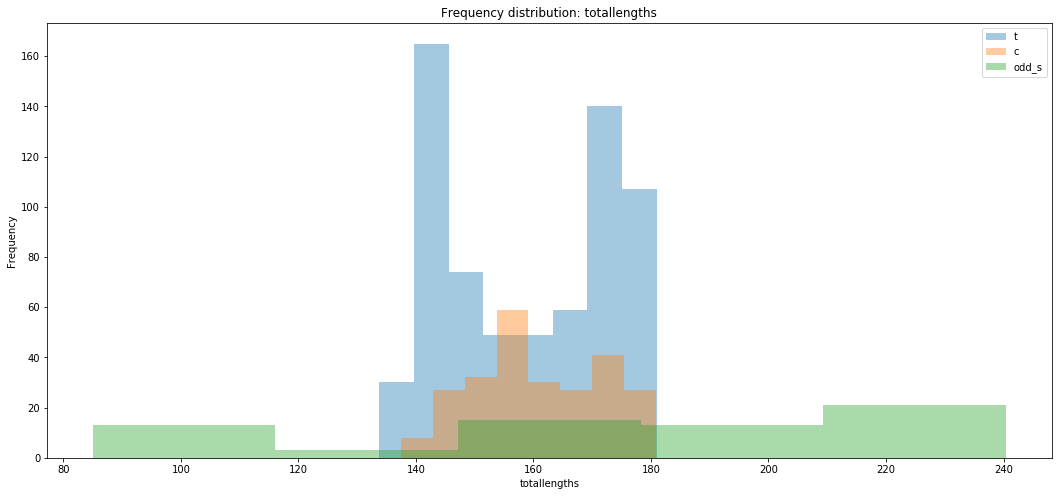

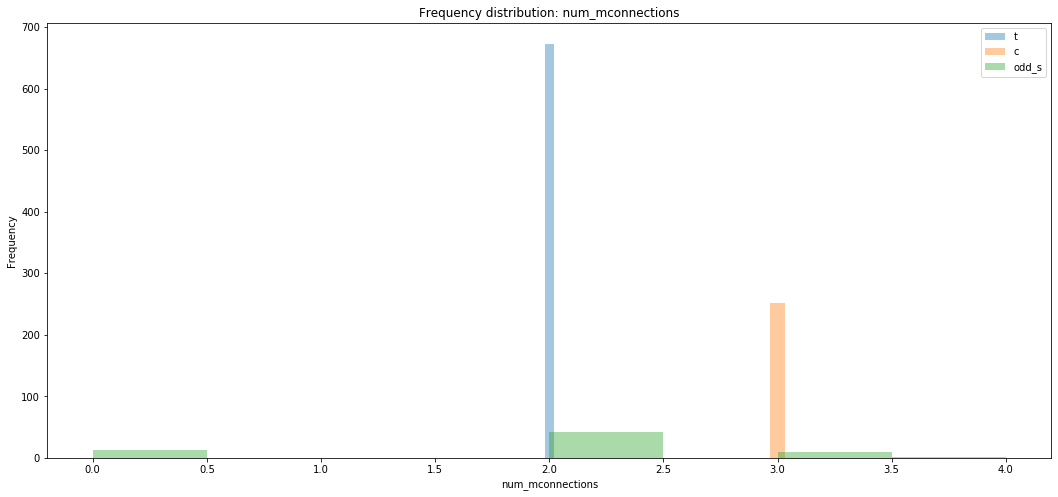

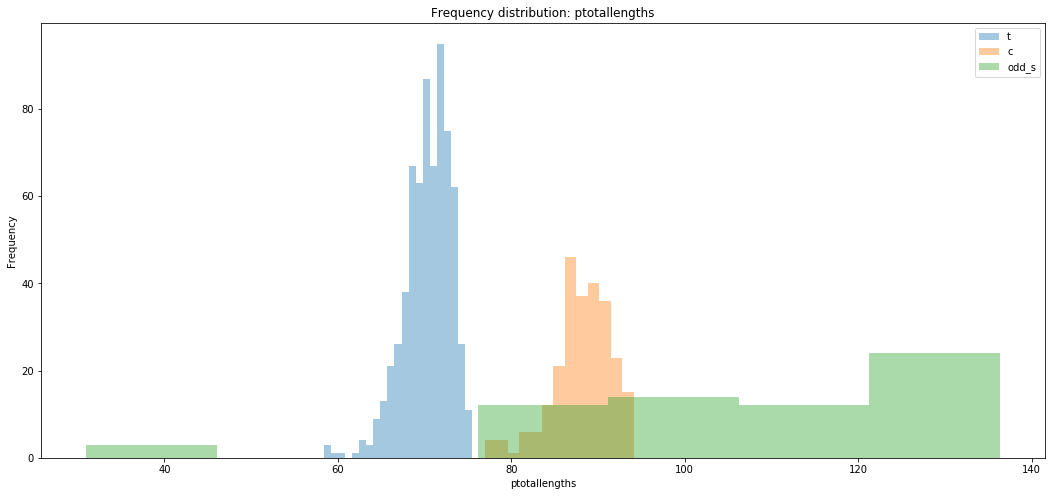

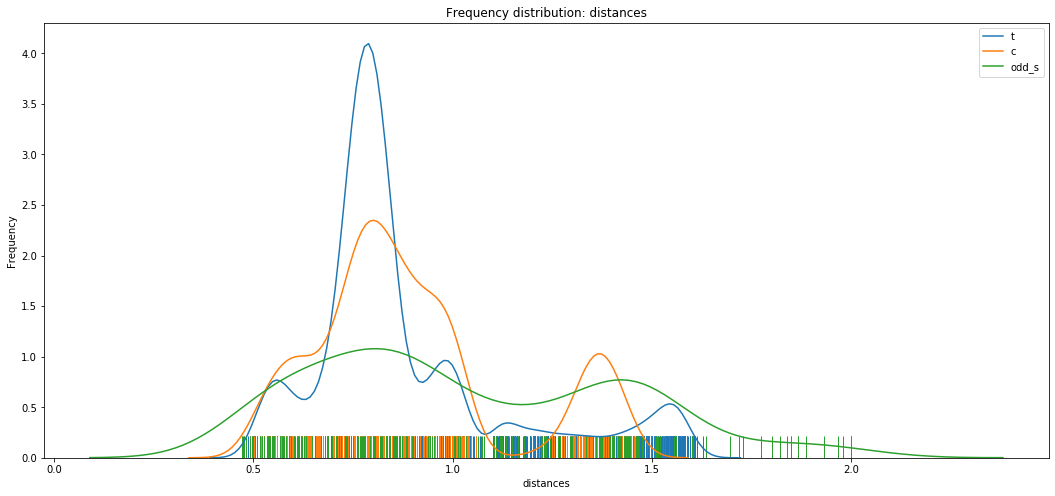

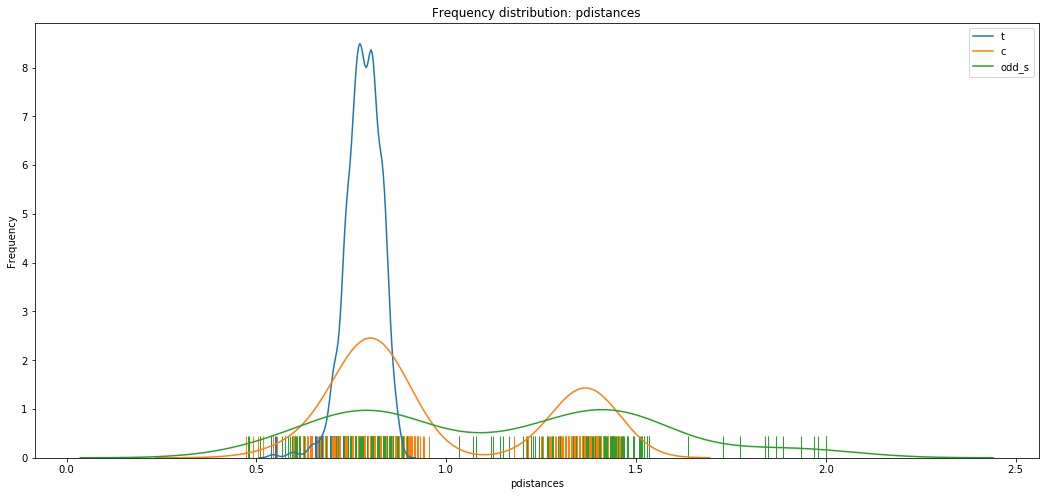

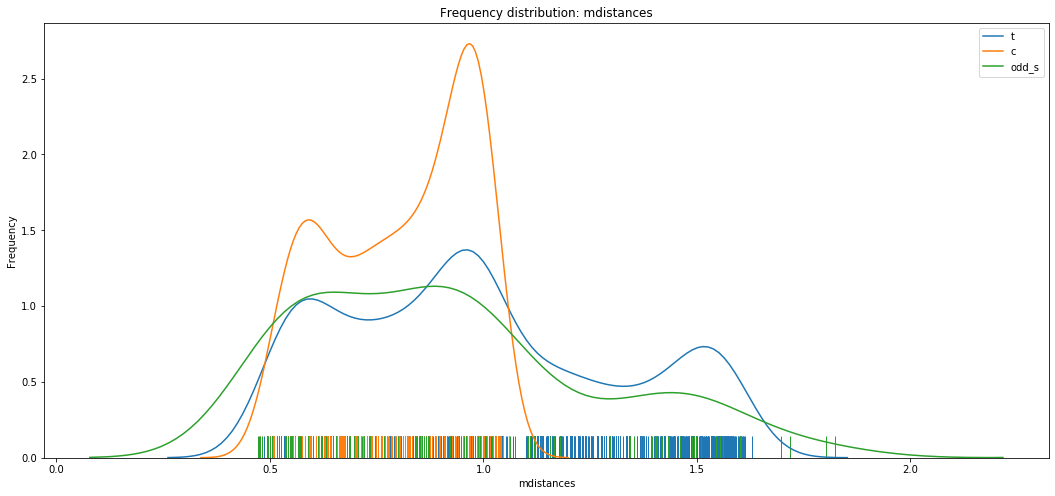

In [12]:

"""Correctly classified"""
# use area information from properties


for name in simplenames:
    klist = []
    for i in range(num_shape_cats):
        x = [h[name] for h in passes[i]]
        klist.append(x) #list of areas for every category
    print("%s averages: " %name)
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: " %name)
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " + name)
    plt.xlabel(name)
    plt.ylabel("Frequency")
    for j in range(0, num_shape_cats-1):
        x = klist[j]
        sns.distplot(x, hist = True, kde=False,rug=False, label = framesetnames[j])
    plt.legend() 
    
    

    
    
print(len(klist[0]))
for name in distances:
    klist = []
    for i in range(num_shape_cats):
        x = [d for lis in [h[name] for h in passes[i]] for d in lis]
        klist.append(x) #list of areas for every category
    print(len(klist[0]))
    print("%s averages: " %name)
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: "  %name)
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " +  name)
    plt.xlabel( name)
    plt.ylabel("Frequency")
    for j in range(0, num_shape_cats-1):
        x = klist[j]
        sns.distplot(x, hist = False, rug=True, label = framesetnames[j])
